Script used to create input for clustering. The output will be a 2D matrix where each row corresponds to a pixel and each column to the intensity of a stain. Some processing and cleaning up is done as well. This includes the adjustment of the mask to only include pixels present in all cycles, the removal of the camera chip background value for all intensities, rescaling of antibody intensities between 0 and 1, as well as the removal of any pixels that only contain antibody intensities below a given threshold value.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from skimage import io
from skimage import (img_as_bool, img_as_uint)
from skimage.exposure import rescale_intensity

In [2]:
def filter_intensities(array, val_threshold, mask):
    print("Filter out low intensity pixels...")
    nrows, ncols, nchan = array.shape
    max_val_img = np.zeros(mask.shape)
    # Get the maximum intensity across all channels for each pixel within the mask
    # "array[mask]" returns an array where the rows are pixels and the columns antibody intensities 
    # using np.amax(..., axis=1) gives back an array with the maximum column of each row
    max_val_img[mask] = np.amax(array[mask], axis=1)
    # Get intersection of the mask and all pixels that aren't low intensity only
    intensity_mask = np.logical_and(mask, max_val_img > val_threshold)
    print("\tNumber of low intensity pixels:", np.sum(max_val_img[mask] <= val_threshold))
    return intensity_mask
        

def rescale_array(array, max_quant): 
    nchan = array.shape[2]
    rescaled_array = np.zeros(array.shape)
    print("Rescaling intensities...")
    for channel in range(nchan):
        print("\tChannel", channel+1, "of", nchan)
        img = array[..., channel] * 1.0  # turn type to float before rescaling
        min_val = 0  # Background already removed
        max_val = np.quantile(img, max_quant)
        img = rescale_intensity(img, in_range=(min_val, max_val))
        rescaled_array[..., channel] = img
    return rescaled_array


def subtract_background(array, val_background):
    # Subtract camera chip background level from all channels and pixels
    print("Removing camera chip background...")
    array = array * 1.0  # Turn to float to potentially allow for negative values 
    bg_adjusted_array = array - val_background
    bg_adjusted_array[bg_adjusted_array < 0] = 0  # Cap values at 0
    return bg_adjusted_array
    

def load_images_and_mask(point, path_point, cycles, ref_cycle, path_mask):
    # Load mask; Needs to be converted to type bool
    mask = img_as_bool(io.imread(str(path_mask)))
    # Create image where "empty" pixels with only low intensities will be noted
    empty_pixels = img_as_bool(np.zeros(mask.shape))
    images = []
    print("Loading images...")
    for cycle in cycles:
        print("\t", cycle)
        filename = point+"_"+cycle+".tif"
        img = io.imread(str(path_point/cycle/filename))
        # Check Hoechst cycle for pixels with intensity 0
        # Add these pixels to the empty_pixels array by taking the union of the two images
        empty_pixels = np.logical_or(empty_pixels, img[..., 2] <= 0)
        # Delete Hoechst channel from all cycles but ref_cycle
        if cycle != ref_cycle:
            img = img[:,:,[0,1,3]]
        # Append image to list
        images.append(img)
    
    # Exclude the empty pixels from the mask. This makes sure we only keep pixels that are present in each cycle
    # Take the intersection of the mask and the inverse of the empty_pixels array
    mask_updated = np.logical_and(mask, np.invert(empty_pixels))
    print("\tNumber of valid pixels in original mask:", sum(sum(mask)))
    print("\tNumber of valid pixels in updated mask:", sum(sum(mask_updated)))
    # Create an array with all the channels along the third dimensions
    print("\tStacking images into one array")
    antibody_array = np.dstack(images)
    return antibody_array, mask_updated


def create_pixel_matrix(point, path_point, cycles, ref_cycle, path_mask, val_background, max_quant, val_threshold):
    # Load images
    antibody_array, mask = load_images_and_mask(point, path_point, cycles, ref_cycle, path_mask)   
    ## Subtract camera chip background level
    #antibody_array = subtract_background(antibody_array, val_background)
    # Rescale intensities
    rescaled_array = rescale_array(antibody_array, max_quant)
    # Remove all pixels with intensities exclusively below val_threshold from mask
    intensity_mask = filter_intensities(rescaled_array, val_threshold, mask)
    # Reshape the array such that each pixel is a row and the columns represent the intensity values
    pixel_matrix = rescaled_array[intensity_mask]
    return pixel_matrix, intensity_mask

At some point it would be nice to include the possibility to specify missing cycles and a cycle whose Hoechst channel should be used. For now I'll just assume that all cycles are present and that the reference cycle is cycle1 because this would require grabbing the Hoechst channel from whichever cycle is specified and moving it into the third position of the array because otherwise the order of antibodies will be different. Can't be bothered to implement that right now.

In [3]:
point = "Point0039"  # The point for which the pixel matrix should be created
alignment_version = "orig_transl_affine"
#path_point =  Path(r"/links/groups/treutlein/USERS/pascal_noser/plate14_results/alignment")/alignment_version/point # path to folder containing all cycles
path_point =  Path(r"/links/groups/treutlein/DATA/imaging/PW/4i/plate14/aligned")/point # path to folder containing all cycles
path_mask = Path(r"/links/groups/treutlein/USERS/pascal_noser/plate14_results/masks/")/alignment_version/(point+"_mask.png")  # path to the mask created using the "mask_creation.ipynb" notebook
path_out = Path(r"/links/groups/treutlein/USERS/pascal_noser/plate14_results/clustering/")/alignment_version/point  # output path for pixel matrix
cycles = ["cycle"+str(x) for x in range(1, 22)]  # List with the names of all cycles used in the clustering
#cycles = ["cycle1", "cycle15"]
missing_cycles = [None]  # list containing the cycles that are missing or should be excluded for this ID
ref_cycle = "cycle1"  # cycle whose Hoechst channel should be used. Most likely the same cycle used as a first reference during the alignment
val_background = 0  # background intensity value of the camera chip
max_quant = 0.98  # the quantile which will be used when rescaling intensities between 0 and 1, where max_quant will be 1
val_threshold = 0.33  # if all anitbody intensities on a pixel are below this threshold, the pixel will be excluded

In [4]:
pixel_matrix, mask = create_pixel_matrix(point, path_point, cycles, ref_cycle, path_mask, val_background, max_quant, val_threshold)

Loading images...
	 cycle1
	 cycle2
	 cycle3
	 cycle4
	 cycle5
	 cycle6
	 cycle7
	 cycle8
	 cycle9
	 cycle10
	 cycle11
	 cycle12
	 cycle13
	 cycle14
	 cycle15
	 cycle16
	 cycle17
	 cycle18
	 cycle19
	 cycle20
	 cycle21
	Number of valid pixels in original mask: 23618540
	Number of valid pixels in updated mask: 23618223
	Stacking images into one array
Rescaling intensities...
	Channel 1 of 64
	Channel 2 of 64
	Channel 3 of 64
	Channel 4 of 64
	Channel 5 of 64
	Channel 6 of 64
	Channel 7 of 64
	Channel 8 of 64
	Channel 9 of 64
	Channel 10 of 64
	Channel 11 of 64
	Channel 12 of 64
	Channel 13 of 64
	Channel 14 of 64
	Channel 15 of 64
	Channel 16 of 64
	Channel 17 of 64
	Channel 18 of 64
	Channel 19 of 64
	Channel 20 of 64
	Channel 21 of 64
	Channel 22 of 64
	Channel 23 of 64
	Channel 24 of 64
	Channel 25 of 64
	Channel 26 of 64
	Channel 27 of 64
	Channel 28 of 64
	Channel 29 of 64
	Channel 30 of 64
	Channel 31 of 64
	Channel 32 of 64
	Channel 33 of 64
	Channel 34 of 64
	Channel 35 of 64
	C

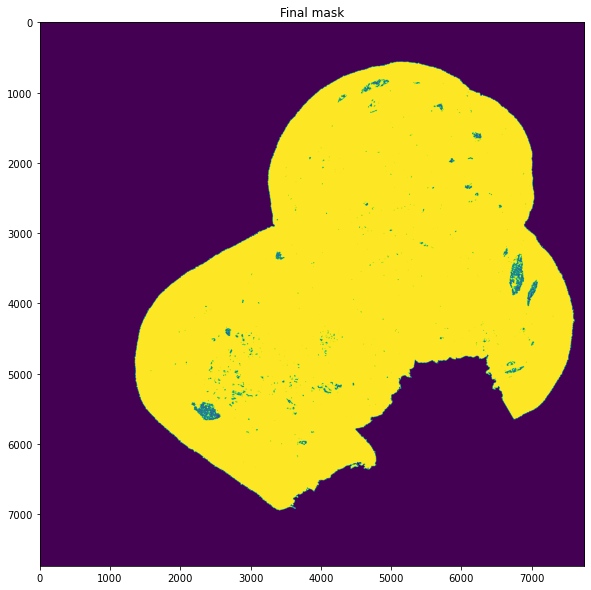

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Final mask")
ax.imshow(mask)
plt.show()

In [6]:
Path(path_out).mkdir(parents=True, exist_ok=True)  # Create output directory
#np.save(path_out/(point+"_matrix.npy"), pixel_matrix)  # Less disk space than csv but can't be easily loaded into R
np.savetxt(path_out/(point+"_matrix.csv"), pixel_matrix, delimiter=",")
io.imsave(path_out/(point+"_final_mask.png"), img_as_uint(mask))

---
Run FlowSOM in R  

---  